<a href="https://colab.research.google.com/github/BhavanaLalwani/Crop-Stress-Analysis/blob/master/Code_Crop_Stress_Analysis___Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
!pip install -q keras

In [0]:
#import keras
import numpy as np
import pandas as pd
import os
import random
from PIL import Image
from random import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras import backend as K

In [0]:
# Cell for hyperparameters
BATCH_SIZE = 15
EPOCHS = 40
#VAL_STEPS = 8  # validation steps
VAL_SPLIT = 0.20  # portion of the training data use for validation
RAND_STATE = 32   #>= 11
LEARNING_RATE = 0.0001

In [0]:
#train_images='/content/gdrive/My Drive/Project C2 Data/ECE542_sp20_CompetitionData/TrainData-C2'
#train_data_folder='/content/gdrive/My Drive/Project C2 Data/ECE542_sp20_CompetitionData/TrainData-C2'
#test_data_folder='/content/gdrive/My Drive/Project C2 Data/ECE542_sp20_CompetitionData/TestData'
#data_path='/content/gdrive/My Drive/Project C2 Data/ECE542_sp20_CompetitionData'

#train_labels_file='/content/gdrive/My Drive/Project C2 Data/ECE542_sp20_CompetitionData/TrainData-C2/TrainAnnotations.csv'
#train_data_folder='/content/gdrive/My Drive/Project C2 Data/ECE542_sp20_CompetitionData/TrainData-C2'
#test_data_folder='/content/gdrive/My Drive/Project C2 Data/ECE542_sp20_CompetitionData/TestData'

In [0]:
#train_images='/content/gdrive/My Drive/Project C2 Data/ECE542_sp20_CompetitionData/TrainData-C2'
train_data_folder='C:\\Users\\MEB\\ECE542_PROJC\\TrainData-C2\\'
data_path='C:\\Projects\\GitHub\\ece542projC\\'

In [0]:
#train_labels='/content/gdrive/My Drive/Project C2 Data/ECE542_sp20_CompetitionData/TrainData-C2/TrainAnnotations.csv'
train_labels_file='C:\\Users\\MEB\\ECE542_PROJC\\TrainC2_Labels\\TrainAnnotations.csv'
C1_train_labels_file = 'C:\\Users\\MEB\\ECE542_PROJC\\Labels\\TrainAnnotations.csv'
print(train_labels_file)
#test_data_folder = 'C:\\Users\\MEB\\ECE542_PROJC\\TrainData\\'  # Defined in cell below prior to test data portion
test_data_folder = 'C:\\Users\\MEB\\ECE542_PROJC\\TestData\\'

C:\Users\MEB\ECE542_PROJC\TrainC2_Labels\TrainAnnotations.csv


In [0]:
#metric creation for Keras
def prec_m(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    pp = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = tp / (pp + K.epsilon())
    return precision

def recall_m(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    pp = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = tp / (pp + K.epsilon())
    return recall

def f1_m(y_true, y_pred):
    precision = prec_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision + recall + K.epsilon()))

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [0]:
names = ['file_name', 'annotation']
data = pd.read_csv(train_labels_file, names=names)
print(data.shape)

(1276, 2)


In [0]:
IMG_WIDTH = 320             # used for downsize (.resize) from 640x480 (320x240)
IMG_HEIGHT = 240
CROP_SQ = 200
PT_A = (IMG_WIDTH/2)-(CROP_SQ/2)      # X axis point 1
PT_B = (IMG_HEIGHT/2)-(CROP_SQ/2)     # Y axis point 1
PT_C = (IMG_WIDTH/2)+(CROP_SQ/2)      # X axis point 2
PT_D = (IMG_HEIGHT/2)+(CROP_SQ/2)     # Y axis point 2

print('A: {}, B: {}, C: {}, D: {}'.format(PT_A,PT_B,PT_C,PT_D))

A: 60.0, B: 20.0, C: 260.0, D: 220.0


In [0]:
def load_training_data():
    train_data = []
    #train_image = []
    #train_label = []

    for x in range(1,len(data)):
        label = data.iloc[x][1]
        img = data.iloc[x][0]
        filename = img
        path = os.path.join(train_data_folder, img)
        img = Image.open(path)
        img = img.convert('RGB')  # L, 1, or RGB
        img = img.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
        rand_shift_x = random.randrange(-1 * PT_A,IMG_WIDTH-PT_C,1)
        rand_shift_y = random.randrange(-1 * PT_B,IMG_HEIGHT-PT_D,1)
        CR_A = PT_A + rand_shift_x
        CR_C = PT_C + rand_shift_x
        CR_B = PT_B + rand_shift_y
        CR_D = PT_D + rand_shift_y
        #img = img.crop((CR_A,CR_B,CR_C,CR_D))  #crop the image [RANDOM LOCATION]
        img = img.crop((PT_A,PT_B,PT_C,PT_D))  #crop the image [CENTER LOCATION]
        train_data.append([np.array(img), label,filename])
        #train_image.append(np.array(img))
        #train_label.append(label)
    #shuffle(train_data)          
    return train_data

In [0]:
train_data = load_training_data()

File Name: 018590.jpg Label: 4 Shape: (200, 200, 3)


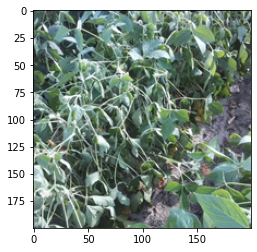

In [0]:
sample_index = 977      # can be any valid training data row index, to test & verify manually 
plt.imshow(train_data[sample_index][0],cmap = 'gray') # print an image, the .jpg file and its label
print('File Name: {} Label: {} Shape: {}'.format(train_data[sample_index][2],train_data[sample_index][1],train_data[sample_index][0].shape))

In [0]:
#Oversampling to balance the data:

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Separate input features and target

df=pd.DataFrame(train_data)
df.columns=['Image','Class','Filename']
y_1 = df.Class
X_1 = df.Image

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

X = pd.concat([X_1, y_1], axis=1)


Class_0 = X[X['Class']=='0']
Class_1 = X[X['Class']=='1']
Class_2 = X[X['Class']=='2']
Class_3 = X[X['Class']=='3']
Class_4 = X[X['Class']=='4']


#Class 0 has highest samples. So we will upsample all other classes to match number of samples in class 0



Class_1_upsampled = resample(Class_1,
                          replace=True, # sample with replacement
                          n_samples=len(Class_0), # match number in majority class
                          random_state=RAND_STATE-11)

Class_2_upsampled = resample(Class_2,
                          replace=True, # sample with replacement
                          n_samples=len(Class_0), # match number in majority class
                          random_state=RAND_STATE+2)

Class_3_upsampled = resample(Class_3,
                          replace=True, # sample with replacement
                          n_samples=len(Class_0), # match number in majority class
                          random_state=RAND_STATE-3)

Class_4_upsampled = resample(Class_4,
                          replace=True, # sample with replacement
                          n_samples=len(Class_0), # match number in majority class
                          random_state=RAND_STATE+9)


upsampled_train_data = pd.concat([Class_0,Class_1_upsampled,Class_2_upsampled,Class_3_upsampled,Class_4_upsampled])

pd.value_counts(upsampled_train_data['Class'])

upsampled_train_data=upsampled_train_data.values.tolist()

In [0]:
def load_training_image():

    train_image = []
    for x in range(0,len(upsampled_train_data)):
        train_image.append(upsampled_train_data[x][0])
    return train_image

In [0]:

def load_training_label():
   
    train_label = []
    for x in range(0,len(upsampled_train_data)):
        train_label.append(upsampled_train_data[x][1])
    return train_label

def load_C1_tr_label():
   
    C1train_label = []
    for x in range(0,len(C1_train_labels)):
        C1train_label.append(C1_train_labels[x][0])
    return C1train_label

train_image = load_training_image()
train_label = load_training_label()


In [0]:
X_train = np.array([x for x in train_image])
Y_train = np.array([x for x in train_label])

X_train = X_train.astype('float32') / 255
train_x = X_train.reshape(len(X_train),CROP_SQ,CROP_SQ,3)
train_y = tf.keras.utils.to_categorical(Y_train,5)  #one-hot encoding
#C1_train_y = tf.keras.utils.to_categorical(C1_Y_train,5)  #one-hot encoding
print('Input Shape (to model): {}'.format(train_x.shape))

Input Shape (to model): (2440, 200, 200, 3)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        3

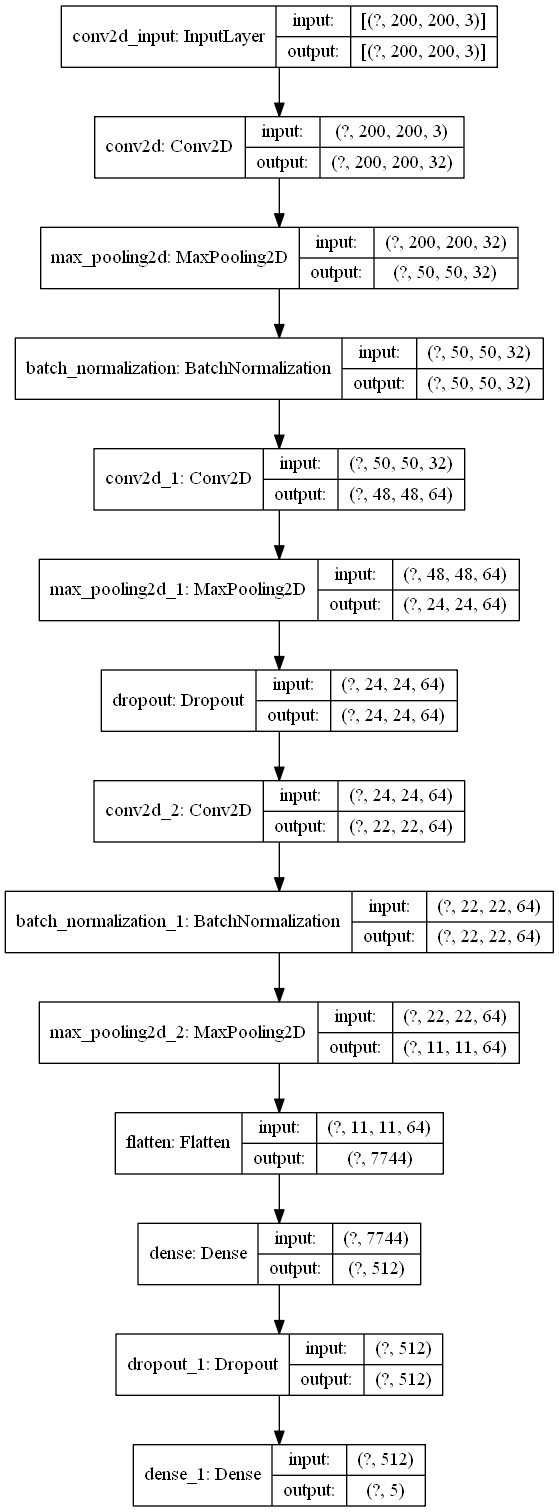

In [0]:

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),padding="same",
                 activation='relu',
                 input_shape=train_x[0].shape))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))
model.summary()
plot_model(model, to_file='C2_CNN_Model2.png', show_shapes=True, show_layer_names=True)

In [0]:
model.compile(Adam(lr=LEARNING_RATE),loss='categorical_crossentropy',metrics=["accuracy",rmse,f1_m, prec_m, recall_m])

In [0]:
#Shuffle Data
from sklearn.utils import shuffle
(train_x,train_y)=shuffle(train_x,train_y)

In [0]:
history = model.fit(train_x,train_y,shuffle=True,validation_split=VAL_SPLIT,batch_size=BATCH_SIZE,epochs=EPOCHS,verbose=1)

Train on 1952 samples, validate on 488 samples
Epoch 1/40
1952/1952 [==============================] - 94s 48ms/sample - loss: 1.1530 - accuracy: 0.6383 - rmse: 0.2390 - f1_m: 0.6291 - prec_m: 0.6635 - recall_m: 0.5997 - val_loss: 1.7015 - val_accuracy: 0.3586 - val_rmse: 0.3911 - val_f1_m: 0.0484 - val_prec_m: 0.3333 - val_recall_m: 0.0263
Epoch 2/40
1952/1952 [==============================] - 87s 45ms/sample - loss: 0.4730 - accuracy: 0.8299 - rmse: 0.1338 - f1_m: 0.8259 - prec_m: 0.8533 - recall_m: 0.8018 - val_loss: 1.3795 - val_accuracy: 0.4795 - val_rmse: 0.3316 - val_f1_m: 0.5238 - val_prec_m: 0.7899 - val_recall_m: 0.3995
Epoch 3/40
1952/1952 [==============================] - 92s 47ms/sample - loss: 0.2758 - accuracy: 0.8970 - rmse: 0.0900 - f1_m: 0.8962 - prec_m: 0.9111 - recall_m: 0.8830 - val_loss: 0.6416 - val_accuracy: 0.7602 - val_rmse: 0.1968 - val_f1_m: 0.7646 - val_prec_m: 0.8496 - val_recall_m: 0.6980
Epoch 4/40
1952/1952 [==============================] - 125s 64ms

In [0]:
accuracy = model.evaluate(x=train_x,y=train_y,batch_size=1)
print("Accuracy: ",accuracy[1])

2440/2440 [==============================] - 42s 17ms/sample - loss: 0.0346 - accuracy: 0.9926 - rmse: 0.0057 - f1_m: 0.9926 - prec_m: 0.9926 - recall_m: 0.9926
Accuracy:  0.992623


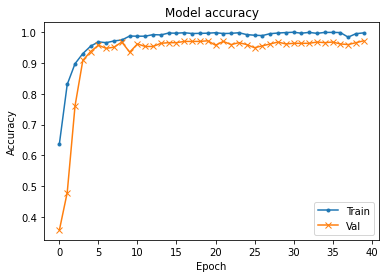

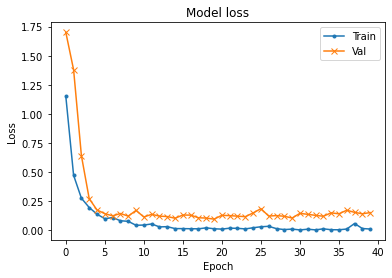

In [0]:

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'],marker=".")
plt.plot(history.history['val_accuracy'],marker="x")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.savefig('Plot_Accuracy.png')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'],marker=".")
plt.plot(history.history['val_loss'],marker="x")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig('Plot_Loss.png')
plt.show()




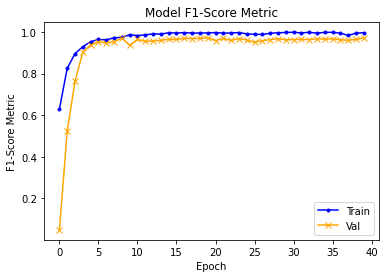

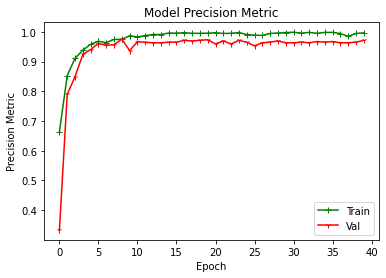

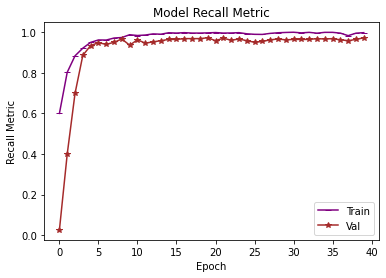

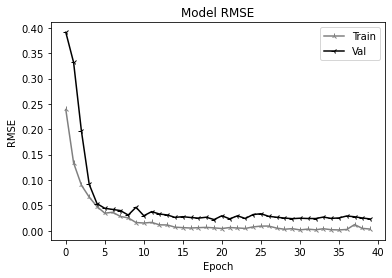

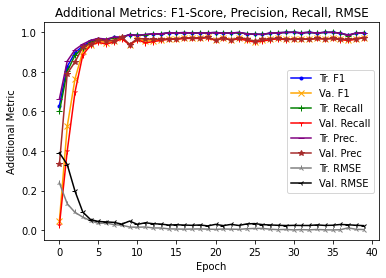

In [0]:
# Plot F1 Metric
plt.plot(history.history['f1_m'],marker=".",color="Blue")
plt.plot(history.history['val_f1_m'],marker="x",color="Orange")
plt.title('Model F1-Score Metric')
plt.ylabel('F1-Score Metric')
plt.xlabel('Epoch')
plt.legend(['Train','Val'], loc='lower right')
plt.savefig('Plot_F1-Score.png')
plt.show()

# Plot prec Metric
plt.plot(history.history['prec_m'],marker="+",color="Green")
plt.plot(history.history['val_prec_m'],marker="1",color="Red")
plt.title('Model Precision Metric')
plt.ylabel('Precision Metric')
plt.xlabel('Epoch')
plt.legend(['Train','Val'], loc='lower right')
plt.savefig('Plot_Precision.png')
plt.show()


# Plot recall Metric
plt.plot(history.history['recall_m'],marker="_",color="Purple")
plt.plot(history.history['val_recall_m'],marker="*",color="Brown")
plt.title('Model Recall Metric')
plt.ylabel('Recall Metric')
plt.xlabel('Epoch')
plt.legend(['Train','Val'], loc='lower right')
plt.savefig('Plot_recall.png')
plt.show()

# Plot RMSE
plt.plot(history.history['rmse'],marker="2",color="Grey")
plt.plot(history.history['val_rmse'],marker="3",color="Black")
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train','Val'], loc='upper right')
plt.savefig('Plot_RMSE.png')
plt.show()

# All 4 New Metrics (Train + Val)
plt.plot(history.history['f1_m'],marker=".",color="Blue")
plt.plot(history.history['val_f1_m'],marker="x",color="Orange")
plt.plot(history.history['recall_m'],marker="+",color="Green")
plt.plot(history.history['val_recall_m'],marker="1",color="Red")
plt.plot(history.history['prec_m'],marker="_",color="Purple")
plt.plot(history.history['val_prec_m'],marker="*",color="Brown")
plt.plot(history.history['rmse'],marker="2",color="Grey")
plt.plot(history.history['val_rmse'],marker="3",color="Black")
plt.title('Additional Metrics: F1-Score, Precision, Recall, RMSE')
plt.ylabel('Additional Metric')
plt.xlabel('Epoch')
plt.legend(['Tr. F1','Va. F1','Tr. Recall','Val. Recall','Tr. Prec.','Val. Prec','Tr. RMSE','Val. RMSE'], loc='center right')
plt.savefig('Plot_F1-Recall-Prec-RMSE.png')
plt.show()


In [0]:
model.save('Idx_84_76BRerun_ProjC2_OvSmpling_Color_Random.hd5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Idx_84_76BRerun_ProjC2_OvSmpling_Color_Random.hd5\assets


In [0]:
#del model

In [0]:
#model = load_model('Idx_ProjC2_OvSmpling_Balance.hd5')

In [0]:
def load_test_data():
    test_data = []
    img_cnt = 0
    #test_image = []
    #train_label = []
####
    for img in os.listdir(test_data_folder):
        path = os.path.join(test_data_folder, img)
        filename = img
        img_cnt = img_cnt + 1
        img = Image.open(path)
        img = img.convert('RGB')  # L, 1, or RGB
        img = img.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
        rand_shift_x = random.randrange(-1 * PT_A,IMG_WIDTH-PT_C,1)
        rand_shift_y = random.randrange(-1 * PT_B,IMG_HEIGHT-PT_D,1)
        CR_A = PT_A + rand_shift_x
        CR_C = PT_C + rand_shift_x
        CR_B = PT_B + rand_shift_y
        CR_D = PT_D + rand_shift_y
        #img = img.crop((PT_A,PT_B,PT_C,PT_D))  #crop the image [CENTER LOCATION]
        img = img.crop((CR_A,CR_B,CR_C,CR_D))  #crop the image  [RANDOM LOCATION, toggle with line above]
        test_data.append([np.array(img),filename])
         
    return (test_data,img_cnt)

In [0]:
test_data,image_count = load_test_data()

In [0]:
def load_test_image():

    test_image = []
    for x in range(0,len(test_data)):
        test_image.append(test_data[x][0])
    return test_image

In [0]:
print('# of Test Images: {}'.format(image_count))

# of Test Images: 200


In [0]:
test_image = load_test_image()
X_test = np.array([x for x in test_image])
X_test = X_test.astype('float32') / 255
test_x = X_test.reshape(len(X_test),CROP_SQ,CROP_SQ,3)
print('Input Shape (to model): {}'.format(test_x[0].shape))

Input Shape (to model): (200, 200, 3)


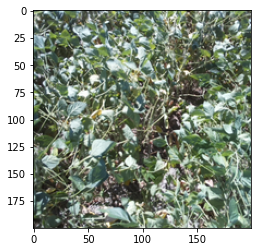

In [0]:
plt.imshow(test_data[1][0],cmap = 'gray')

In [0]:
def set_train_predictions():
    train_pred = model.predict(x=train_x)
    train_prediction = []
    for x in range(0,len(train_pred)):
        train_prediction.append([train_data[x][2],np.argmax(train_pred[x]),train_data[x][1]]) #filename,prediction,annotation
    return train_prediction

In [0]:
def set_test_predictions():
    test_pred = model.predict(x=test_x)
    test_prediction = []
    test_pred_dist = []
    for x in range(0,len(test_pred)):
        testpred = np.argmax(test_pred[x])
        tp_ohe = tf.keras.utils.to_categorical(testpred,5).astype('int')
        test_prediction.append([test_data[x][1],testpred,tp_ohe[0],tp_ohe[1],tp_ohe[2],tp_ohe[3],tp_ohe[4]])
        test_pred_dist.append(testpred)
    return test_prediction,test_pred_dist

In [0]:
test_prediction,test_pred_dist = set_test_predictions()
#train_prediction = set_train_predictions()

In [0]:
pd.DataFrame(test_prediction,columns = ["File Name","Prediction","P[0]","P[1]","P[2]","P[3]","P[4]"]).to_csv(data_path+'Idx84_Center-Random_test_predictions.csv',header=True,index=False)

In [0]:
pd.Series(test_pred_dist).value_counts()

1    92
0    46
4    43
3    13
2     6
dtype: int64